In [1]:
%pip install ultralytics pyyaml -q

Note: you may need to restart the kernel to use updated packages.


In [2]:
import os
import shutil
import yaml
from ultralytics import YOLO


In [3]:
# 원본 데이터셋 경로 (data.yaml이 있는 폴더)
original_dataset = './PPE-1'

# 필터링된 데이터셋 저장 경로
filtered_dataset = './ppe_filtered'

# 원하는 클래스 ID: 0=Hardhat, 2=Safety_Boots, 3=Safety_Gloves
wanted_classes = [0, 2, 3]


In [4]:
def filter_yolo_labels(original_label_path, output_label_path, wanted_class_ids):
    with open(original_label_path, 'r') as f:
        lines = f.readlines()
    
    filtered_lines = [line for line in lines if int(line.split()[0]) in wanted_class_ids]
    
    if filtered_lines:
        with open(output_label_path, 'w') as f:
            f.writelines(filtered_lines)
        return True
    return False

def filter_yolo_dataset(original_path, output_path, wanted_ids):
    for split in ['train', 'valid', 'test']:
        img_dir = os.path.join(original_path, split, 'images')
        lbl_dir = os.path.join(original_path, split, 'labels')
        
        if not os.path.exists(img_dir):
            continue
        
        out_img_dir = os.path.join(output_path, split, 'images')
        out_lbl_dir = os.path.join(output_path, split, 'labels')
        os.makedirs(out_img_dir, exist_ok=True)
        os.makedirs(out_lbl_dir, exist_ok=True)
        
        count = 0
        for lbl_file in os.listdir(lbl_dir):
            if not lbl_file.endswith('.txt'):
                continue
            
            orig_lbl = os.path.join(lbl_dir, lbl_file)
            out_lbl = os.path.join(out_lbl_dir, lbl_file)
            
            if filter_yolo_labels(orig_lbl, out_lbl, wanted_ids):
                img_name = os.path.splitext(lbl_file)[0]
                for ext in ['.jpg', '.jpeg', '.png', '.JPG']:
                    img_file = img_name + ext
                    orig_img = os.path.join(img_dir, img_file)
                    if os.path.exists(orig_img):
                        shutil.copy2(orig_img, os.path.join(out_img_dir, img_file))
                        count += 1
                        break
        
        print(f'[{split}] {count}개 이미지-라벨 쌍 복사 완료')


In [5]:
def update_class_ids(dataset_path, old_to_new):
    for split in ['train', 'valid', 'test']:
        lbl_dir = os.path.join(dataset_path, split, 'labels')
        if not os.path.exists(lbl_dir):
            continue
        
        for lbl_file in os.listdir(lbl_dir):
            if not lbl_file.endswith('.txt'):
                continue
            
            lbl_path = os.path.join(lbl_dir, lbl_file)
            with open(lbl_path, 'r') as f:
                lines = f.readlines()
            
            updated = []
            for line in lines:
                parts = line.split()
                parts[0] = str(old_to_new[int(parts[0])])
                updated.append(' '.join(parts) + '\n')
            
            with open(lbl_path, 'w') as f:
                f.writelines(updated)
    
    print('클래스 ID 재조정 완료')


In [6]:
def create_yaml(orig_yaml, out_yaml, wanted_ids, out_path):
    with open(orig_yaml, 'r', encoding='utf-8') as f:
        data = yaml.safe_load(f)
    
    orig_names = data['names']
    new_names = []
    old_to_new = {}
    
    for new_id, old_id in enumerate(wanted_ids):
        new_names.append(orig_names[old_id])
        old_to_new[old_id] = new_id
    
    new_data = {
        'path': out_path,
        'train': 'train/images',
        'val': 'valid/images',
        'test': 'test/images',
        'names': new_names,
        'nc': len(new_names)
    }
    
    with open(out_yaml, 'w', encoding='utf-8') as f:
        yaml.dump(new_data, f, default_flow_style=False, allow_unicode=True)
    
    print(f'새 data.yaml 생성: {new_names}')
    return old_to_new


In [9]:
print('=== 데이터 필터링 시작 ===')
filter_yolo_dataset(original_dataset, filtered_dataset, wanted_classes)

orig_yaml = os.path.join(original_dataset, 'data.yaml')
new_yaml = os.path.join(filtered_dataset, 'data.yaml')

mapping = create_yaml(orig_yaml, new_yaml, wanted_classes, filtered_dataset)
update_class_ids(filtered_dataset, mapping)
print('=== 필터링 완료 ===\n')


=== 데이터 필터링 시작 ===
[train] 5050개 이미지-라벨 쌍 복사 완료
[valid] 506개 이미지-라벨 쌍 복사 완료
[test] 241개 이미지-라벨 쌍 복사 완료
새 data.yaml 생성: ['Hardhat', 'Safety_Boots', 'Safety_Gloves']
클래스 ID 재조정 완료
=== 필터링 완료 ===



In [ ]:
model = YOLO('yolov11n.pt')

results = model.train(
    data=new_yaml,
    epochs=100,
    imgsz=640,
    batch=16,
    workers=2,
    name='ppe_detection',
    patience=10,
    save=True,
    plots=True
)


New https://pypi.org/project/ultralytics/8.3.204 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.203  Python-3.8.20 torch-2.4.1 CUDA:0 (NVIDIA GeForce RTX 4050 Laptop GPU, 6140MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=./ppe_filtered\data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=100, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=ppe_detection2, nbs=64,

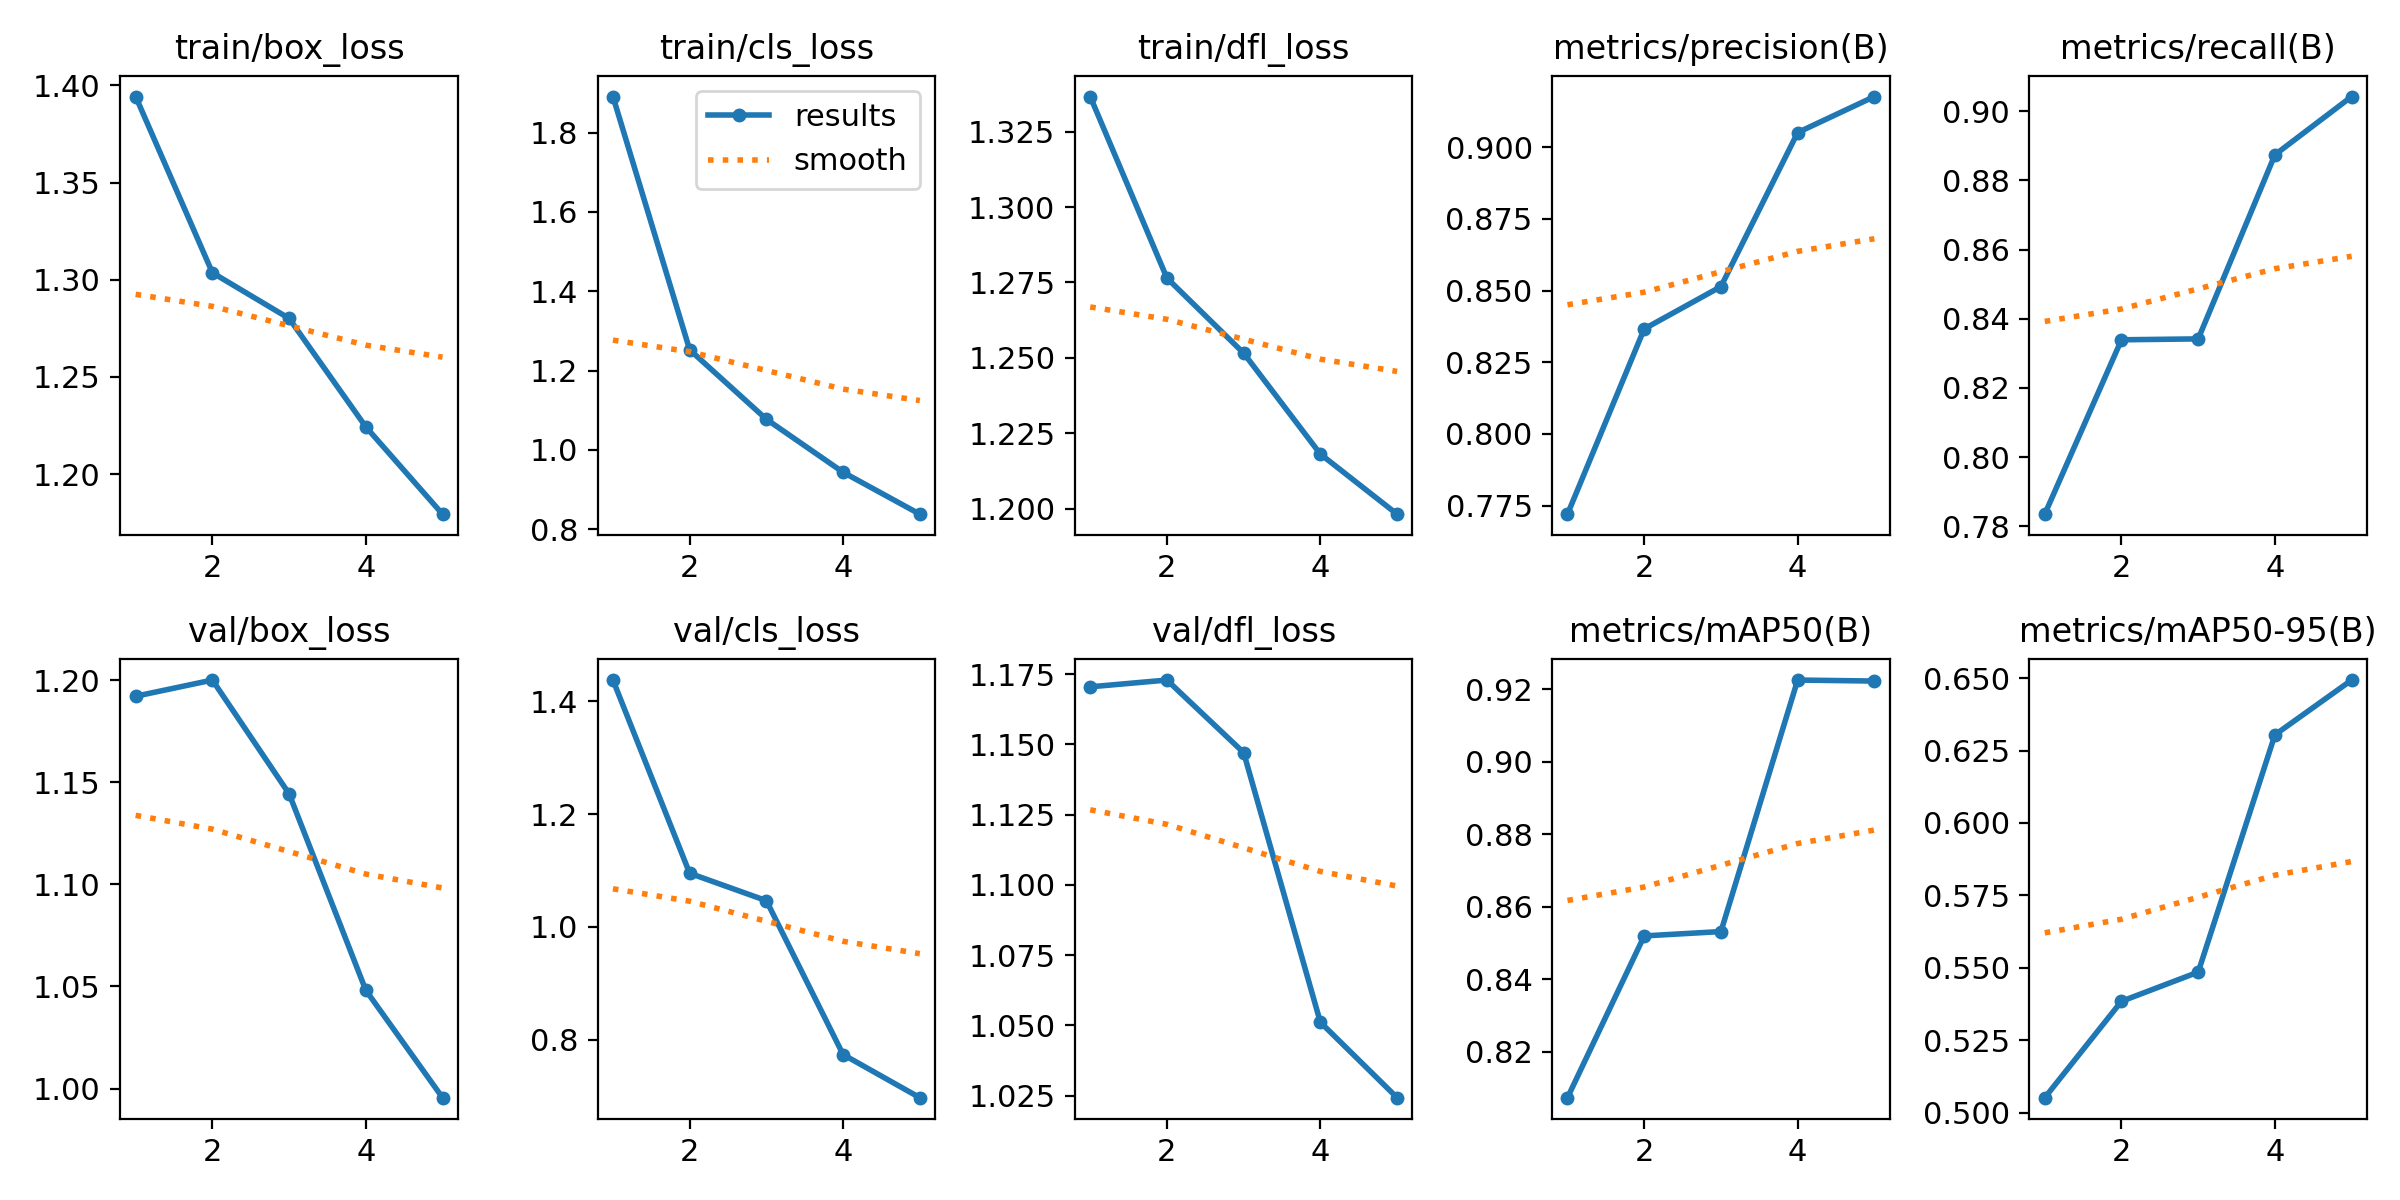

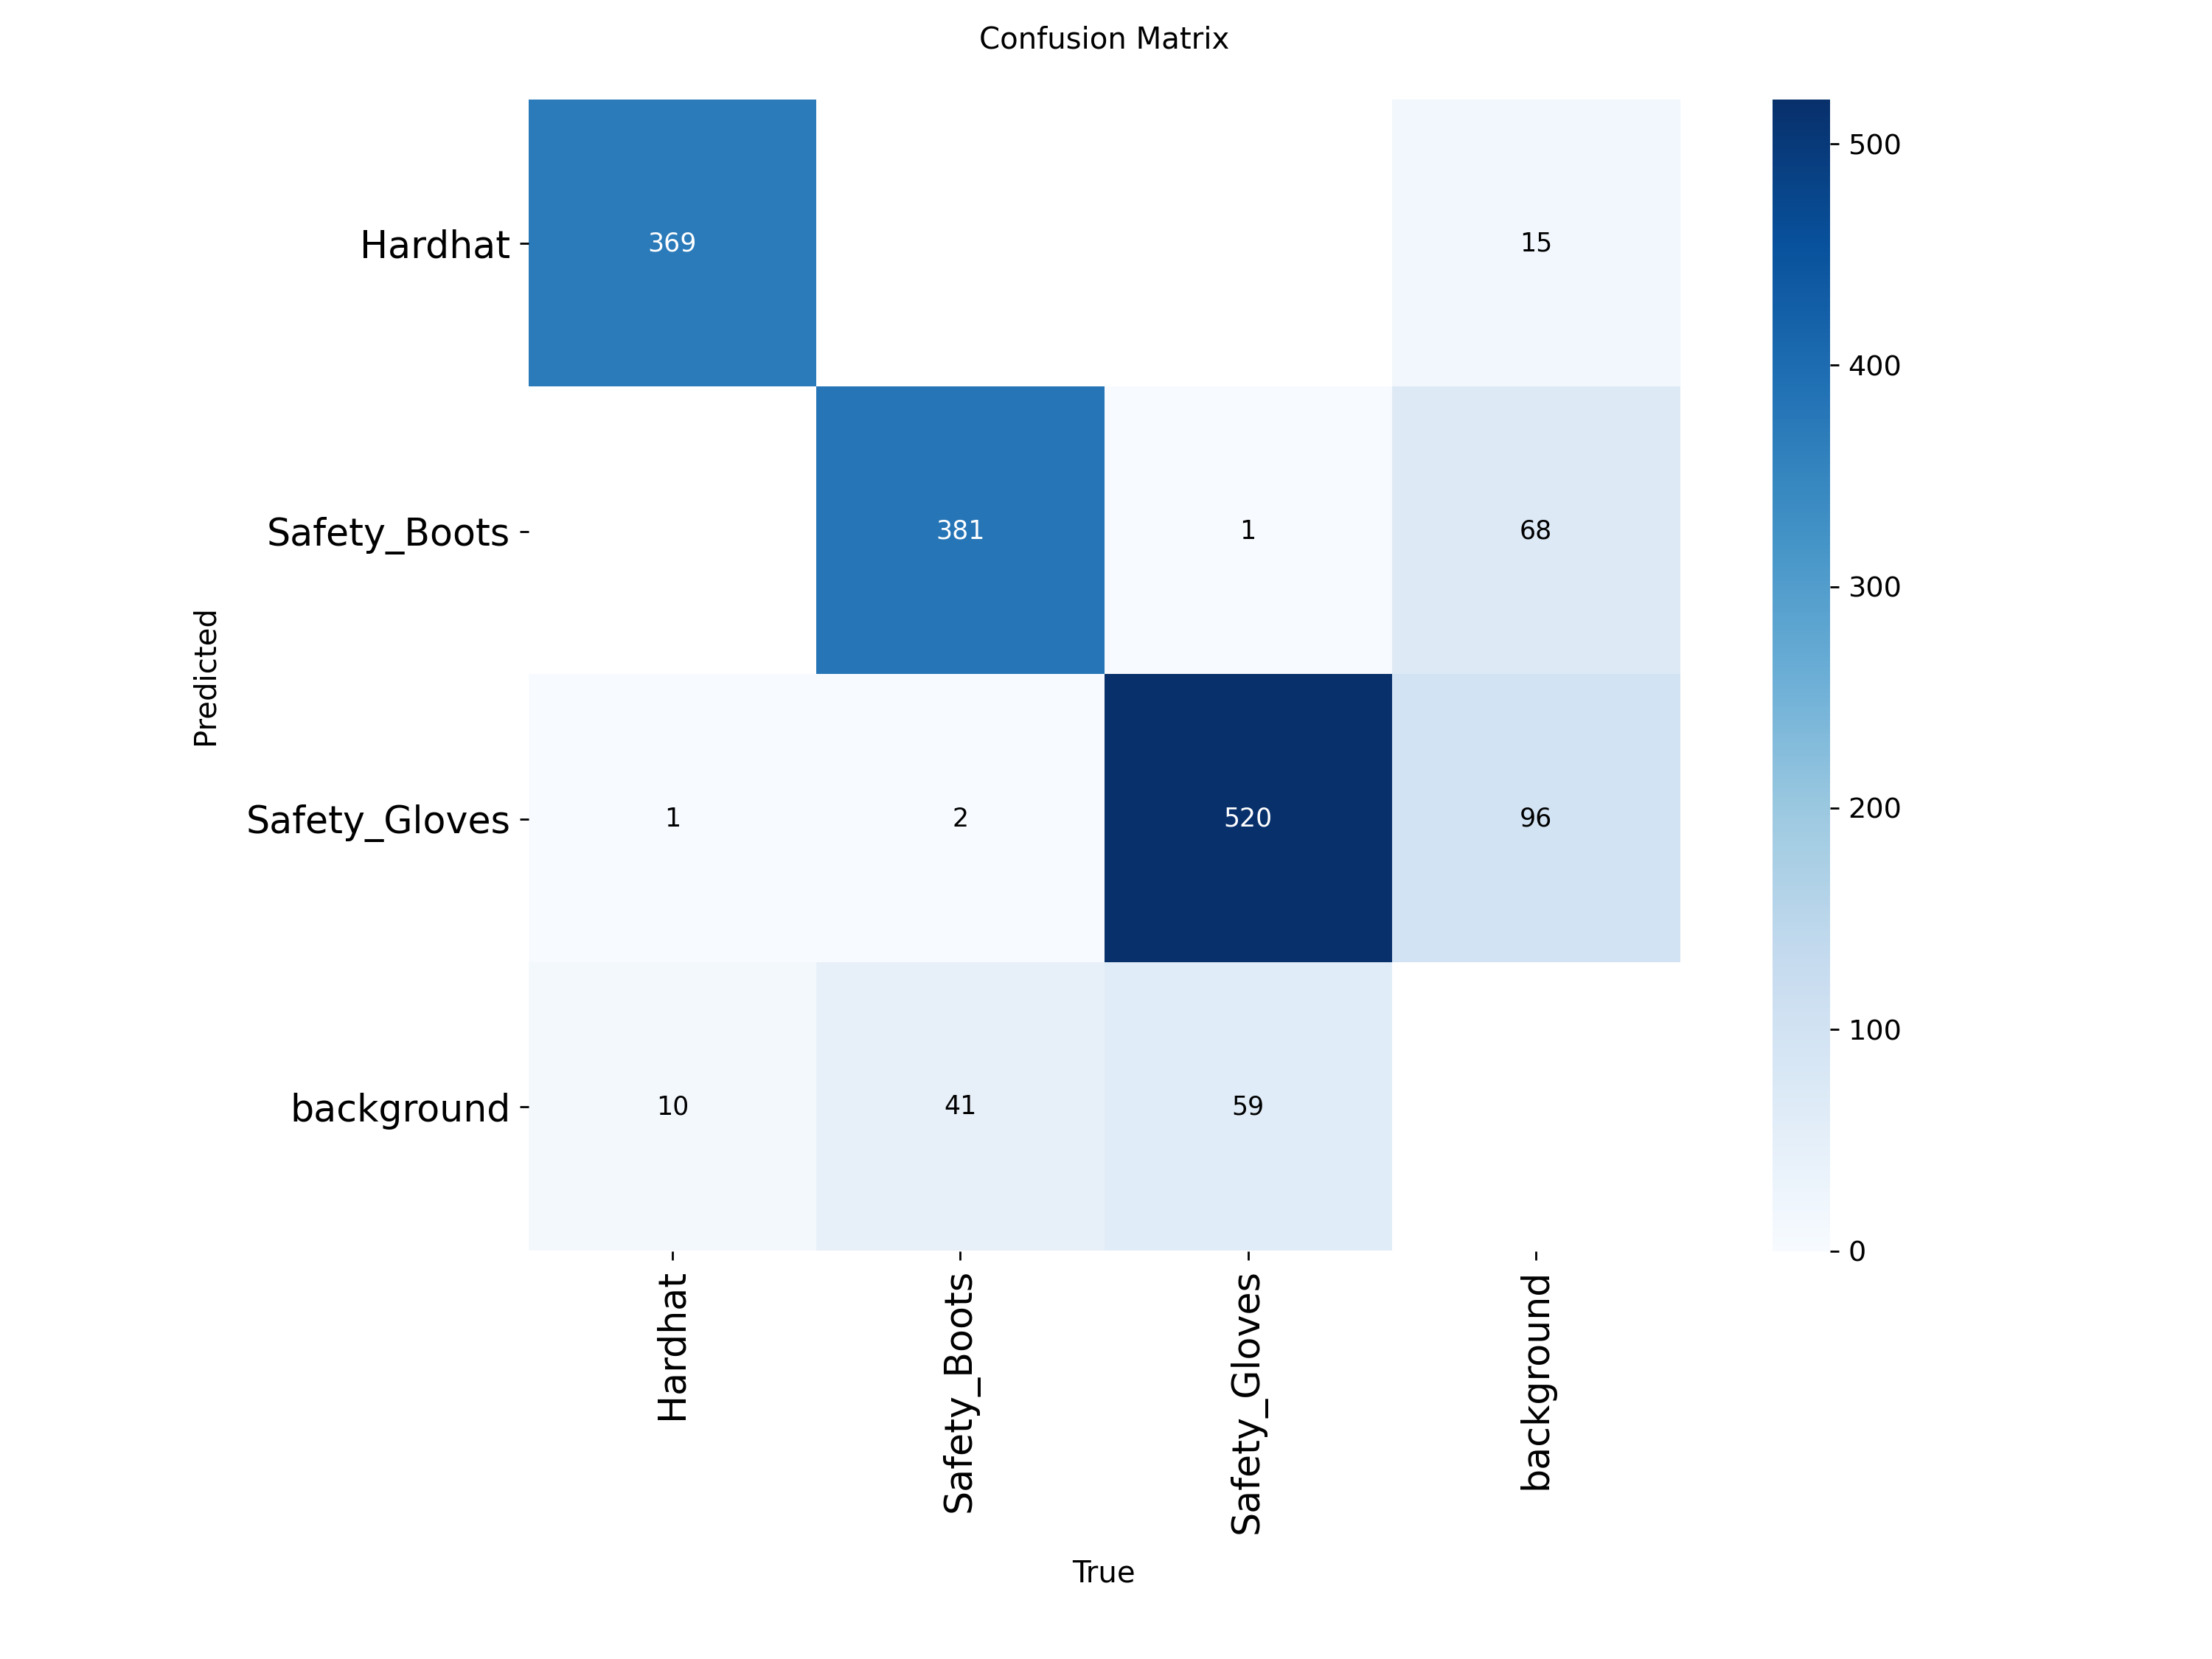

In [11]:
from IPython.display import Image, display

display(Image(filename='runs/detect/ppe_detection/results.png'))
display(Image(filename='runs/detect/ppe_detection/confusion_matrix.png'))


In [17]:
model = YOLO('runs/detect/ppe_detection2/weights/best.pt')

metrics = model.val(data=new_yaml)

print(f'mAP50: {metrics.box.map50:.3f}')
print(f'mAP50-95: {metrics.box.map:.3f}')


Ultralytics 8.3.203  Python-3.8.20 torch-2.4.1 CUDA:0 (NVIDIA GeForce RTX 4050 Laptop GPU, 6140MiB)
Model summary (fused): 72 layers, 3,006,233 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.40.1 ms, read: 74.716.9 MB/s, size: 37.6 KB)
val: Scanning C:\Users\Admin\capstone\ppe_filtered\valid\labels.cache... 506 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 506/506 31.6Kit/s 0.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 32/32 2.8it/s 11.6s0.2s
                   all        506       1384      0.945      0.922      0.958      0.724
               Hardhat        354        380      0.989      0.977      0.991      0.863
          Safety_Boots        218        424      0.912      0.903      0.941        0.6
         Safety_Gloves        313        580      0.935      0.886      0.942       0.71
Speed: 0.6ms preprocess, 4.8ms inference, 0.0ms loss, 3.5ms postprocess per image
Results saved to C:\

In [ ]:
test_img_dir = os.path.join(filtered_dataset, 'test/images')

results = model.predict(
    source=test_img_dir,
    save=True,
    conf=0.25,
    project='runs/detect',
    name='test_results',
    exist_ok=True
)

print(f'테스트 결과 저장 위치: runs/detect/test_results')



image 1/241 C:\Users\Admin\capstone\ppe_filtered\test\images\00095_jpg.rf.b36499ea7ddf505365a448a7e1de22fc.jpg: 640x640 (no detections), 25.0ms
image 2/241 C:\Users\Admin\capstone\ppe_filtered\test\images\00275_jpg.rf.46dd3430bb3c0f3108859a04c2679eb5.jpg: 640x640 1 Hardhat, 24.5ms
image 3/241 C:\Users\Admin\capstone\ppe_filtered\test\images\00322_jpg.rf.761dec991be9a4d30e099a8d7fa09199.jpg: 640x640 1 Hardhat, 1 Safety_Boots, 24.5ms
image 4/241 C:\Users\Admin\capstone\ppe_filtered\test\images\0_13753316_jpg.rf.9077b210447bbfe797a24120ca325d6f.jpg: 640x640 1 Hardhat, 23.0ms
image 5/241 C:\Users\Admin\capstone\ppe_filtered\test\images\0_13830817_jpg.rf.099691fb79a7b610e80ca7583e39b300.jpg: 640x640 1 Hardhat, 22.6ms
image 6/241 C:\Users\Admin\capstone\ppe_filtered\test\images\0_13962360_jpg.rf.d0dbf5d004cb9ccea1571ac485a010fe.jpg: 640x640 1 Hardhat, 23.1ms
image 7/241 C:\Users\Admin\capstone\ppe_filtered\test\images\0_16573536_jpg.rf.8528c0ee4a042aeb5b7557d39f84a083.jpg: 640x640 1 Hardhat

In [21]:
import glob

test_images = glob.glob(os.path.join(test_img_dir, '*.jpg'))[:3]

for img_path in test_images:
    results = model(img_path)
    results[0].plot()
    results[0].show()



image 1/1 C:\Users\Admin\capstone\ppe_filtered\test\images\00095_jpg.rf.b36499ea7ddf505365a448a7e1de22fc.jpg: 640x640 (no detections), 26.3ms
Speed: 5.1ms preprocess, 26.3ms inference, 2.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\Admin\capstone\ppe_filtered\test\images\00275_jpg.rf.46dd3430bb3c0f3108859a04c2679eb5.jpg: 640x640 1 Hardhat, 26.8ms
Speed: 7.3ms preprocess, 26.8ms inference, 4.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\Admin\capstone\ppe_filtered\test\images\00322_jpg.rf.761dec991be9a4d30e099a8d7fa09199.jpg: 640x640 1 Hardhat, 1 Safety_Boots, 26.1ms
Speed: 7.4ms preprocess, 26.1ms inference, 4.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\Admin\capstone\ppe_filtered\test\images\0_13753316_jpg.rf.9077b210447bbfe797a24120ca325d6f.jpg: 640x640 1 Hardhat, 26.1ms
Speed: 7.2ms preprocess, 26.1ms inference, 4.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\Admin\capstone\pp

KeyboardInterrupt: 

In [20]:
shutil.copy('runs/detect/ppe_detection2/weights/best.pt', './ppe_best_model.pt')
print('모델이 ./ppe_best_model.pt로 저장되었습니다')


모델이 ./ppe_best_model.pt로 저장되었습니다
